Feature shape after flattening: (8199, 25088)

===== Running for 2 components =====
PCA + KMEANS → ACC=0.566, ARI=-0.080, NMI=0.105
PCA + GMM → ACC=0.557, ARI=-0.078, NMI=0.096
TSNE + KMEANS → ACC=0.550, ARI=-0.001, NMI=0.047
TSNE + GMM → ACC=0.504, ARI=-0.055, NMI=0.090


/home/prema/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP + KMEANS → ACC=0.520, ARI=-0.015, NMI=0.033
UMAP + GMM → ACC=0.502, ARI=-0.022, NMI=0.028


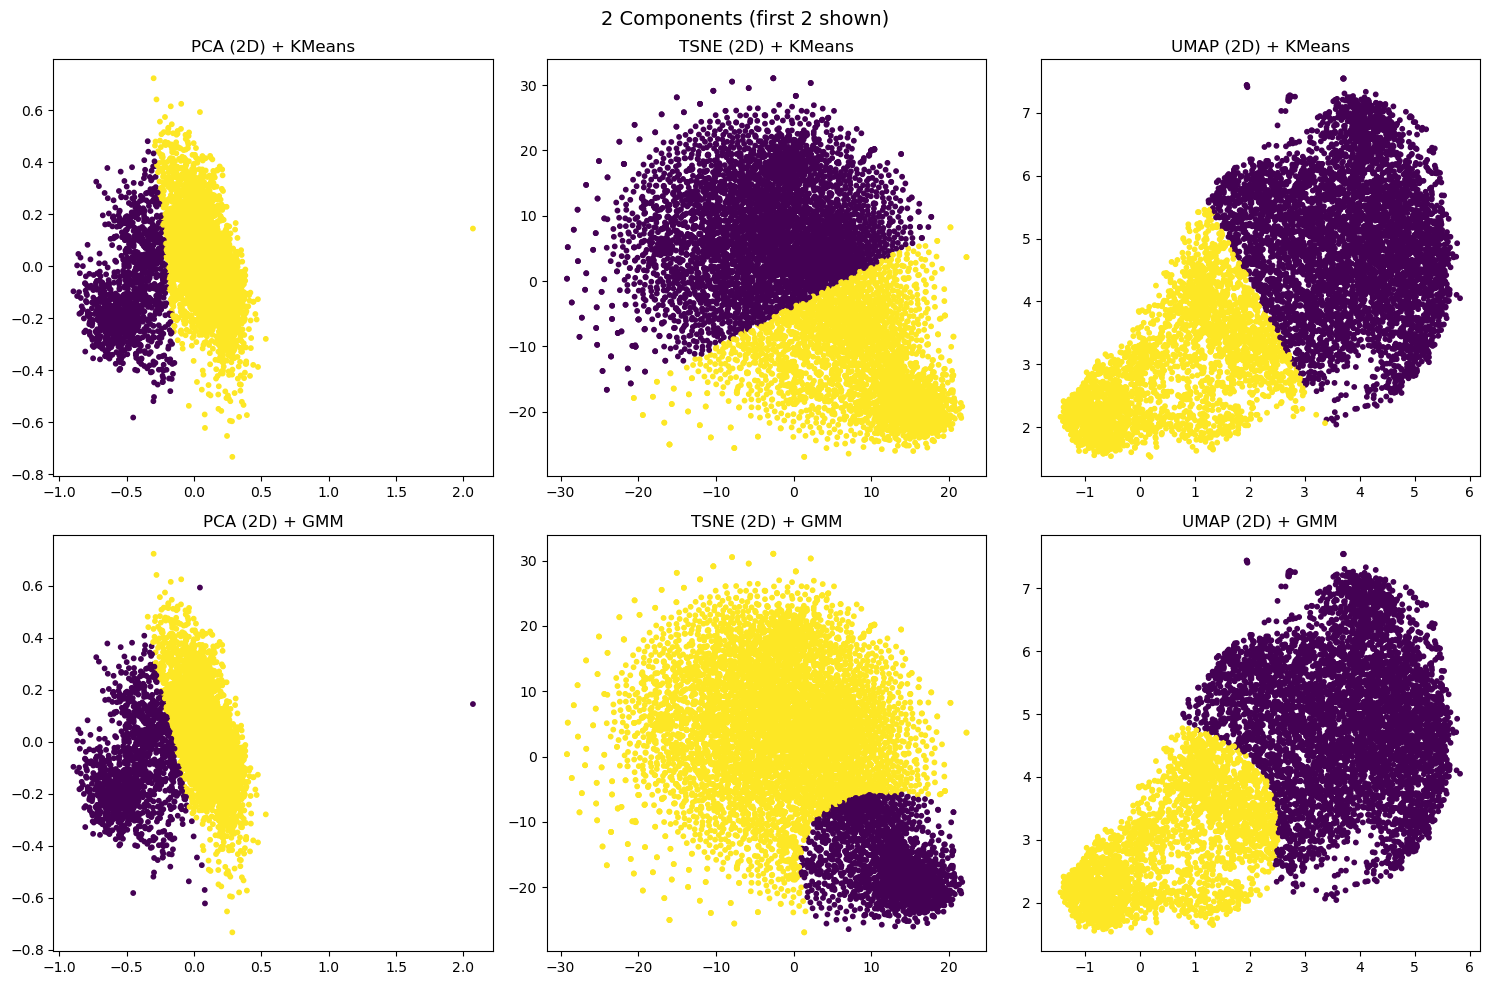


===== Running for 4 components =====
PCA + KMEANS → ACC=0.565, ARI=-0.081, NMI=0.108
PCA + GMM → ACC=0.519, ARI=-0.069, NMI=0.116
TSNE + KMEANS → ACC=0.589, ARI=0.032, NMI=0.037
TSNE + GMM → ACC=0.713, ARI=-0.000, NMI=0.000


/home/prema/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP + KMEANS → ACC=0.513, ARI=-0.038, NMI=0.040
UMAP + GMM → ACC=0.532, ARI=-0.051, NMI=0.047


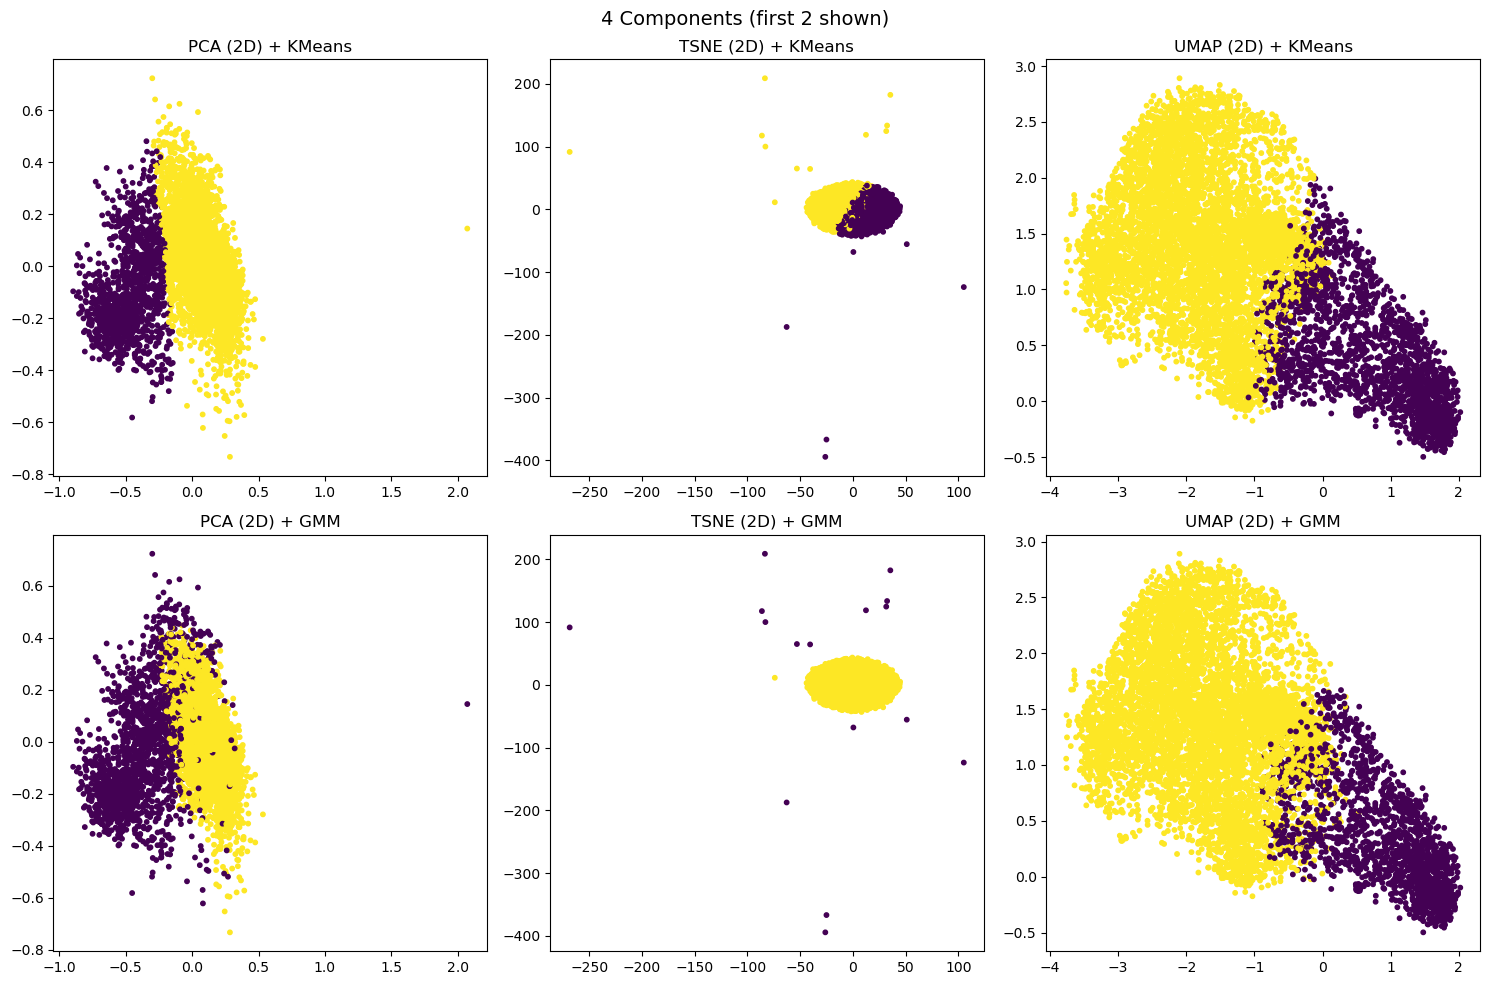


Final Results:
   Dim_Reduction  Components Clustering       ARI       NMI  Silhouette  \
0            pca           2     kmeans -0.080481  0.105160    0.595040   
1            pca           2        gmm -0.077511  0.095703    0.580148   
2           tsne           2     kmeans -0.000984  0.046752    0.468372   
3           tsne           2        gmm -0.054713  0.089675    0.440324   
4           umap           2     kmeans -0.015077  0.032526    0.506887   
5           umap           2        gmm -0.022392  0.027707    0.505272   
6            pca           4     kmeans -0.080766  0.108306    0.482883   
7            pca           4        gmm -0.068669  0.116079    0.434362   
8           tsne           4     kmeans  0.031678  0.036741    0.186404   
9           tsne           4        gmm -0.000293  0.000021    0.788932   
10          umap           4     kmeans -0.038055  0.039812    0.479167   
11          umap           4        gmm -0.050895  0.046584    0.481300   

        

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import umap.umap_ as umap

from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    silhouette_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from scipy.spatial.distance import cdist


# -----------------------------
# Load features and labels
# -----------------------------
feat_path  = "/nmhs2/prema/imageprocessing/imagenet-autoencoder/results/features/features.pth"
label_path = "/nmhs2/prema/imageprocessing/imagenet-autoencoder/results/features/labels.pth"

X = torch.load(feat_path).cpu().numpy()
y_true = torch.load(label_path).cpu().numpy()

# ---- REQUIRED FIX (sklearn expects 2D) ----
X = X.reshape(X.shape[0], -1)
print("Feature shape after flattening:", X.shape)


# -----------------------------
# Dimensionality Reduction
# -----------------------------
def reduce_dimensionality(X, method, n_components):

    if method == "pca":
        return PCA(n_components=n_components, random_state=42).fit_transform(X)

    if method == "tsne":
        return TSNE(
            n_components=n_components,
            perplexity=30,
            random_state=42,
            method="exact"
        ).fit_transform(X)

    if method == "umap":
        return umap.UMAP(
            n_components=n_components,
            random_state=42
        ).fit_transform(X)

    raise ValueError("Unknown dimensionality reduction method")


# -----------------------------
# Clustering
# -----------------------------
def cluster_data(X, method, n_clusters=2):

    if method == "kmeans":
        return KMeans(n_clusters=n_clusters, random_state=42).fit_predict(X)

    if method == "gmm":
        return GaussianMixture(
            n_components=n_clusters,
            random_state=42
        ).fit_predict(X)

    raise ValueError("Unknown clustering method")


# -----------------------------
# ICC metric
# -----------------------------
def compute_icc(X, labels):

    icc = 0
    for c in np.unique(labels):
        pts = X[labels == c]
        center = pts.mean(axis=0)
        icc += np.mean(cdist(pts, center.reshape(1, -1)))

    return icc / len(np.unique(labels))


# -----------------------------
# Align cluster labels
# -----------------------------
def align_labels(y_true, y_pred):

    acc1 = accuracy_score(y_true, y_pred)
    acc2 = accuracy_score(y_true, 1 - y_pred)

    return y_pred if acc1 >= acc2 else 1 - y_pred


# -----------------------------
# Grid Plot Function
# -----------------------------
def plot_cluster_grid(X_dict, y_dict, n_comp):

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"{n_comp} Components (first 2 shown)", fontsize=14)

    methods = ["pca", "tsne", "umap"]

    # ---- Row 1: KMeans ----
    for i, m in enumerate(methods):
        axes[0, i].scatter(
            X_dict[m][:, 0],
            X_dict[m][:, 1],
            c=y_dict[(m, "kmeans")],
            s=10
        )
        axes[0, i].set_title(f"{m.upper()} (2D) + KMeans")

    # ---- Row 2: GMM ----
    for i, m in enumerate(methods):
        axes[1, i].scatter(
            X_dict[m][:, 0],
            X_dict[m][:, 1],
            c=y_dict[(m, "gmm")],
            s=10
        )
        axes[1, i].set_title(f"{m.upper()} (2D) + GMM")

    plt.tight_layout()
    plt.show()


# -----------------------------
# Main Experiment Loop
# -----------------------------
results = []

for n_comp in [2, 4]:

    print(f"\n===== Running for {n_comp} components =====")

    X_reduced = {}
    y_clustered = {}

    # ---- Dimensionality Reduction ----
    for red_method in ["pca", "tsne", "umap"]:

        X_red = reduce_dimensionality(X, red_method, n_comp)
        X_reduced[red_method] = X_red

        # ---- Clustering ----
        for clu_method in ["kmeans", "gmm"]:

            y_pred = cluster_data(X_red, clu_method)
            y_pred = align_labels(y_true, y_pred)

            y_clustered[(red_method, clu_method)] = y_pred

            # ---- Metrics ----
            ari = adjusted_rand_score(y_true, y_pred)
            nmi = normalized_mutual_info_score(y_true, y_pred)
            sil = silhouette_score(X_red, y_pred)
            icc = compute_icc(X_red, y_pred)

            acc  = accuracy_score(y_true, y_pred)
            prec = precision_score(y_true, y_pred)
            rec  = recall_score(y_true, y_pred)
            f1   = f1_score(y_true, y_pred)

            print(f"{red_method.upper()} + {clu_method.upper()} → "
                  f"ACC={acc:.3f}, ARI={ari:.3f}, NMI={nmi:.3f}")

            results.append({
                "Dim_Reduction": red_method,
                "Components": n_comp,
                "Clustering": clu_method,
                "ARI": ari,
                "NMI": nmi,
                "Silhouette": sil,
                "ICC": icc,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1_score": f1
            })

    # ---- Plot once per n_comp ----
    plot_cluster_grid(X_reduced, y_clustered, n_comp)


# -----------------------------
# Results Table
# -----------------------------
df_results = pd.DataFrame(results)
print("\nFinal Results:")
print(df_results)
